In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date
import calendar
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
import xgboost as xgb
from sklearn.metrics import classification_report
from lifetimes.utils  import summary_data_from_transaction_data
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('./Data/Blended_Data_Features_Removed.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Cust Type,Customer No.,District,Invoice Date,Job Card No,Labour Total,Make,Misc Total,Model,OSL Total,...,Name 2,House number and street,PO Box,City,Sales organization,ServiceTime_category,Description,Item Category,Order Quantity,Net value
0,Retail,80479,Maharashtra,2015-06-19,227460,1802.05,FORD,0.0,FIESTA,0.0,...,Mumbai,"8, Mira, Behind Ajit Palace Ho",401104.0,Thane,MFCB,super_fast,"DISTILLED WATER, Paid Service-Minor, REPLACE H...","P001, P002",45.5,2201.78
1,Retail,E15810,Maharashtra,2016-07-20,413455,2874.80,MARUTI SUZUKI,0.0,SWIFT,0.0,...,Mumbai,"8, Mira, Behind Ajit Palace Ho",401104.0,Thane,MFCB,mid,"REPLACE FRONT SHOCK ABSORBER RHS, OIL FILTER-S...","P001, P002",202.5,6025.86
2,Retail,E15810,Maharashtra,2016-09-04,446448,2799.96,MARUTI SUZUKI,0.0,SWIFT,0.0,...,Mumbai,"8, Mira, Behind Ajit Palace Ho",401104.0,Thane,MFCB,super_slow,"REPLACE CAMSHAFT OIL SEAL, MISC LABOR 0.5 HOUR...","P001, P002",189.0,3464.00
3,Retail,73857,Maharashtra,2016-10-28,487708,554.95,HYUNDAI,0.0,VERNA,0.0,...,Mumbai,"8, Mira, Behind Ajit Palace Ho",401104.0,Thane,MFCB,super_slow,"MFC PROLEUM C14/SL 15W40, OIL FILTER VENTO, Pa...","P001, P002",7.0,2065.75
4,Retail,E25519,Maharashtra,2015-05-28,220109,75.02,MAHINDRA & MAHINDRA,0.0,LOGAN D,0.0,...,Mumbai,"8, Mira, Behind Ajit Palace Ho",401104.0,Thane,MFCB,super_fast,"WIPER T, NOZZLE-LH WS WASHER, REMOVE & REFIT W...","P001, P002",13.0,653.45


In [40]:
summary=summary_data_from_transaction_data(df,'Customer No.','Invoice Date',monetary_value_col='Net value',observation_period_end='2016')

In [41]:
summary

,frequency,recency,T,monetary_value
Customer No.,,,,
100001,2.0,210.0,256.0,1602.655000
100003,0.0,0.0,258.0,0.000000
100004,0.0,0.0,258.0,0.000000
100006,0.0,0.0,256.0,0.000000
100007,1.0,243.0,258.0,4224.440000
...,...,...,...,...
MFCCM04,1.0,73.0,807.0,39513.980000
MFCCM14,12.0,1332.0,1345.0,41618.335833
MFCCM15,1.0,92.0,1341.0,6055.910000


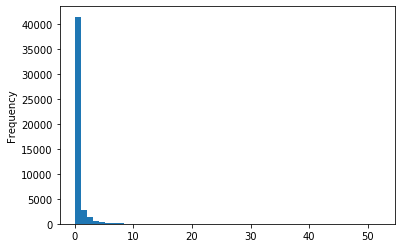

In [20]:
summary['frequency'].plot(kind='hist',bins=50)

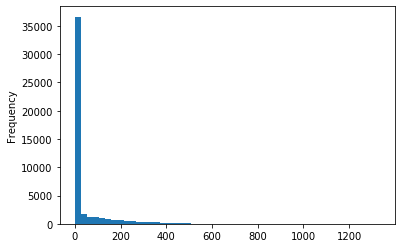

In [21]:
summary['recency'].plot(kind='hist',bins=50)

In [22]:
from lifetimes import BetaGeoFitter
bgf=BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'],summary['recency'],summary['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 47178 subjects, a: 1.29, alpha: 58.84, b: 2.86, r: 0.27>


In [23]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.266902,0.004469,0.258142,0.275662
alpha,58.838075,1.540878,55.817955,61.858195
a,1.285122,0.103663,1.081943,1.488301
b,2.862238,0.272488,2.328161,3.396315


In [24]:
t=10

summary['pred_num']=round(bgf.conditional_expected_number_of_purchases_up_to_time(t,summary['frequency'],summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num', ascending=False).head(10)

,frequency,recency,T,monetary_value,pred_num
Customer No.,,,,,
MFCCM03,52.0,310.0,312.0,9799.239423,1.34
E11328,23.0,161.0,162.0,11713.277391,0.97
E2003,44.0,561.0,562.0,42056.542955,0.69
104031,15.0,226.0,234.0,1112.023333,0.46
120968,13.0,112.0,135.0,4713.404615,0.46
58803,32.0,579.0,598.0,1396.296250,0.44
E11308,24.0,304.0,336.0,17623.180833,0.44
75256,23.0,430.0,437.0,999.990870,0.43
124525,5.0,37.0,39.0,1078.948000,0.43


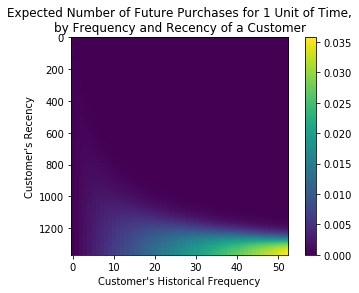

In [25]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

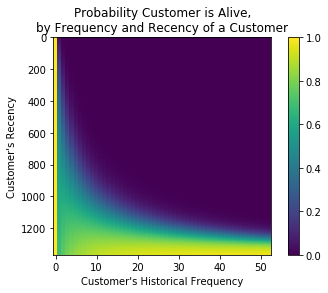

In [26]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

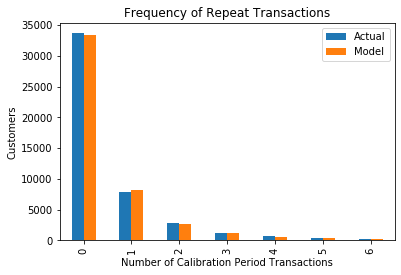

In [27]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [35]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'Customer No.', 'Invoice Date',
                                        calibration_period_end='2016-08-31',
                                        observation_period_end='2016-10-31' )
print(summary_cal_holdout.head())

              frequency_cal  recency_cal  T_cal  frequency_holdout  \
Customer No.                                                         
100001                  2.0        210.0  499.0                0.0   
100003                  0.0          0.0  501.0                0.0   
100004                  0.0          0.0  501.0                0.0   
100006                  0.0          0.0  499.0                0.0   
100007                  4.0        473.0  501.0                0.0   

              duration_holdout  
Customer No.                    
100001                      61  
100003                      61  
100004                      61  
100006                      61  
100007                      61  


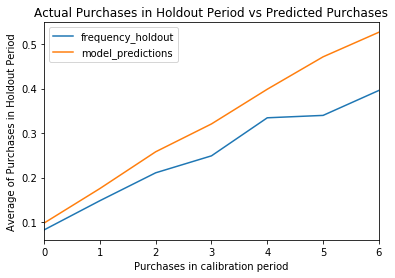

In [36]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [59]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(summary[['recency']])
summary['RecencyCluster'] = kmeans.predict(summary[['recency']])

In [60]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(summary[['frequency']])
summary['FrequencyCluster'] = kmeans.predict(summary[['frequency']])

In [62]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(summary[['monetary_value']])
summary['RevenueCluster'] = kmeans.predict(summary[['monetary_value']])

In [64]:
#overall scoring
summary['OverallScore'] = summary['RecencyCluster'] + summary['FrequencyCluster'] + summary['RevenueCluster']
summary['Segment'] = 'Low-Value'
summary.loc[summary['OverallScore']>2,'Segment'] = 'Mid-Value' 
summary.loc[summary['OverallScore']>4,'Segment'] = 'High-Value' 

In [65]:
summary

,frequency,recency,T,monetary_value,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment
Customer No.,,,,,,,,,
100001,2.0,210.0,256.0,1602.655000,0,2,0,2,Low-Value
100003,0.0,0.0,258.0,0.000000,1,0,0,1,Low-Value
100004,0.0,0.0,258.0,0.000000,1,0,0,1,Low-Value
100006,0.0,0.0,256.0,0.000000,1,0,0,1,Low-Value
100007,1.0,243.0,258.0,4224.440000,0,2,0,2,Low-Value
...,...,...,...,...,...,...,...,...,...
MFCCM04,1.0,73.0,807.0,39513.980000,1,2,1,4,Mid-Value
MFCCM14,12.0,1332.0,1345.0,41618.335833,3,3,1,7,High-Value
MFCCM15,1.0,92.0,1341.0,6055.910000,0,2,3,5,High-Value


In [6]:
RevenueDF = df[['Customer No.','Invoice Date','Net value']]

In [7]:
RevenueDF.head()

,Customer No.,Invoice Date,Net value
0,80479,2015-06-19,2201.78
1,E15810,2016-07-20,6025.86
2,E15810,2016-09-04,3464.00
3,73857,2016-10-28,2065.75
4,E25519,2015-05-28,653.45


In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
pip install fbprophet